# Detecting pairwise H-bond between protein and ligand at each milestone

In this note book, we will use the **search_hbonds** function to compute H-bonds between protein-ligand and protein-solvent-ligand. The representaive clusters (with water molecules) generated in **RepreFrame_sparse** will be used to perform the H-bond analysis 

## Load Libraries

In [3]:
import sys
sys.path.append('./modules/')
sys.path.insert(1,'/hdd/si_han/cpptraj_test/pytraj') 

import pytraj as pt
from sklearn.decomposition import PCA
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from interpolateCurve import interpolateCurve
from log_progress import*
from LineBuilder import*

## Load representative clusters frames

In [4]:
reaction_path = '/hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6_restrt'
path_id = 0  # specify which path you want to write/load
milestone_path=reaction_path+'/Milestone_%d'%path_id
hbond_path = milestone_path+'/H-bonds'
%cd {hbond_path}

watertop = '/hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6/water.prmtop'#reaction_path+'/water.prmtop'
repre_cluster = pt.iterload(hbond_path+'/selected_restrt.dcd',watertop)
repre_cluster

/hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6_restrt/Milestone_0/H-bonds


pytraj.TrajectoryIterator, 1134 frames: 
Size: 2.943051 (GB)
<Topology: 116111 atoms, 35881 residues, 35264 mols, PBC with box type = ortho>
           

## Obtain resname of the ligand
In this example, the ligand is the 620th residue of the system, indexed as 619 in python. We use the following command to extract the resname of the ligand. You can also use VMD to obtain the resname.

In [5]:
ligand_name = [residue.name for residue in repre_cluster.top.residues][619]
ligand_name

'MOL'

## Load milestone index and frame index of representative clusters
You should've all the input files save previously from **Milesoning_Generate** and **RepreFrame_sparse**.

In [4]:
idx2_ = np.load(hbond_path+'/selected_frameidx.npy')
idx_ = np.load(hbond_path+'/selected_midx.npy')

In [5]:
num_milestones = len(list(set(idx_)))

In [6]:
#Using cpptraj to obtain solute-solute, solute-solvent, and solute-solvent-solute H-bons
frameidx = np.array(range(len(repre_cluster)))
for i in log_progress(range(num_milestones)):
    data = pt.search_hbonds(repre_cluster[frameidx[idx_ == i]],
                            distance=3.0, angle=150,
                            solvent_donor=':WAT@O', solvent_acceptor=':WAT',
                           options='avgout UU_%d.dat solvout UV_%d.dat bridgeout bridge_%d.dat'%(i,i,i))

/home/si_han/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


### BASH commands
run the following commands in bash

In [7]:
print("command 1: cd "+hbond_path)
print('command 2: for i in $(ls bridge*); do grep "%s" $i > ${i/_/_%s_}; done'%(ligand_name,ligand_name))

command 1: cd /hdd/si_han/Project/CDK8/metadynamics/WeiChen_VM2_candidates/002_C301-8809/100ns_seed6_restrt/Milestone_0/H-bonds
command 2: for i in $(ls bridge*); do grep "MOL" $i > ${i/_/_MOL_}; done


## Plot Protein-Ligand Hbonds

In [7]:
Hbond_UU = []
for i in range(num_milestones):
    test = pd.read_csv('UU_%d.dat'%i,sep='\s+|_|@', engine='python',skiprows=1,header=None
                      ,names=['AccepterR','Accepter id','Accepter','DonorR','Donor id','DonorH','DonorR 2',
                            'Donor id 2','Donor','Frames','Frac','AvgDist','AvgAng']
                      )
    
    df1= test[test['AccepterR']=='MOL']
    df2 = test[test['DonorR']=='MOL']
    Hbond_UU.append(pd.concat([df1,df2]))

In [8]:
Hbond_UU_data = []
for k in range(num_milestones):
    if len(Hbond_UU[k]) > 0:
        for i in range(len(Hbond_UU[k])):
            if Hbond_UU[k]['AccepterR'].iloc[i]=='MOL' and Hbond_UU[k]['DonorR'].iloc[i] !='MOL':
                Hbond_UU_data.append([ k, Hbond_UU[k]['DonorR'].iloc[i],Hbond_UU[k]['Donor id'].iloc[i],
                                     Hbond_UU[k]['Accepter'].iloc[i], Hbond_UU[k]['AvgDist'].iloc[i]])
            elif Hbond_UU[k]['DonorR'].iloc[i]=='MOL' and Hbond_UU[k]['AccepterR'].iloc[i]!='MOL':
                Hbond_UU_data.append([ k, Hbond_UU[k]['AccepterR'].iloc[i],Hbond_UU[k]['Accepter id'].iloc[i],
                                     Hbond_UU[k]['DonorH'].iloc[i], Hbond_UU[k]['AvgDist'].iloc[i]])

In [16]:
index=list(range(len(Hbond_UU_data)))
columns=['milestone','residue','residue id','ligand atom','AvgDist']
df_UU = pd.DataFrame(Hbond_UU_data,index=index,columns=columns)
df_UU["residue id"] = pd.to_numeric(df_UU["residue id"])
df_UU.to_csv(hbond_path+'/df_UU.csv', sep='\t', index=False)
Rorder = np.sort(np.array(list(set(np.array(df_UU.iloc[:,2])))))

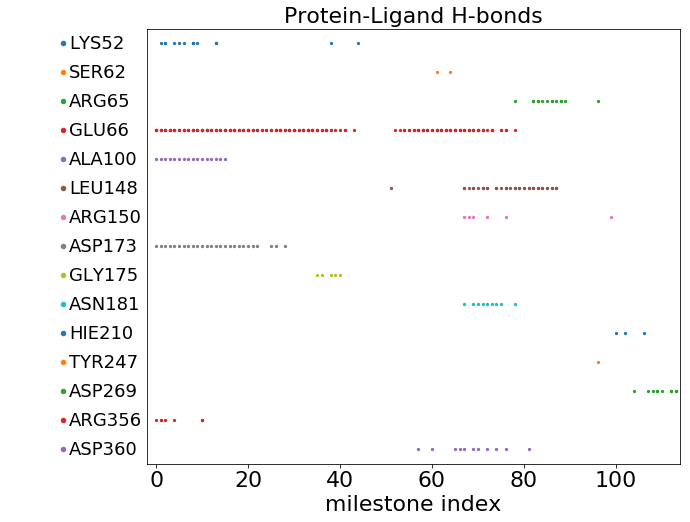

In [17]:
plt.figure(figsize=(12,8))

# subplot 1 for y-ticks and bullet points
fig = plt.subplot2grid((10, 10), (0, 0), rowspan=10)

x = 1.1
for i in range(len(Rorder)):
    y = len(Rorder)-i    
    plt.scatter(x,y,s=20)
    R = df_UU[df_UU.iloc[:,2]==Rorder[i]].iloc[0,1]
    plt.text(x+0.13,y-0.2, "%-3s%-d"%(R,int(Rorder[i])),fontsize=18)

plt.xlim(0,1.2)
plt.ylim(0.5,len(Rorder)+0.5)
plt.yticks(np.arange(1, len(Rorder)+1, 1.0))
plt.yticks([])

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

#########################################################################################################

# subplot 2 for H bonds
fig = plt.subplot2grid((10, 10), (0, 2), colspan=9,rowspan=10)
x = np.array(df_UU.iloc[:,0])
y = np.array(df_UU.iloc[:,2])
for i in range(len(Rorder)):
    index = y == Rorder[i]
    x_ = x[index]
    y_ = [len(Rorder)-i]*len(x_)
    plt.scatter(x_,y_,s=5)

plt.setp(fig.get_yticklabels(),visible=False)
plt.yticks([])
plt.ylim(0.5,len(Rorder)+0.5)
plt.xlim([-2,num_milestones])
plt.xlabel("milestone index",fontsize=22)
plt.title("Protein-Ligand H-bonds",fontsize=22)
plt.tick_params(labelsize=22)
plt.savefig('/home/si_han/Desktop/uf/WeiChen/002_UU.pdf')
plt.show()

## Plot Protein-Solvent-Ligand Hbonds

In [24]:
import os

Hbond_bridge = []
for i in range(num_milestones):
    file = 'bridge_MOL_%d.dat'%i
    if os.path.exists(file)==False or os.stat(file).st_size == 0:
        Hbond_bridge.append([])
    else:
        tmp = pd.read_csv(file,sep='\s+|:|,',engine='python',header=None, names=list(range(16)))
        tmp = tmp[[2,3,4,5,6,7,8,9,10,11]]
        tmp.columns=['Res 1 id','Res 1','Res 2 id','Res 2','Res 3 id','Res 3','Res 4 id','Res 4','Res 5 id','Res 5']
        Hbond_bridge.append(tmp)

In [27]:
pd.read_csv('bridge_MOL_%d.dat'%0,sep='\s+|:|,',engine='python',header=None, names=list(range(16)))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Bridge,Res,66,GLU,620,MOL,NaN,NaN,3,frames.,NaN,NaN,NaN,NaN,NaN,NaN
1,Bridge,Res,27,VAL,620,MOL,NaN,NaN,1,frames.,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
Hbond_bridge[40]

,Res 1 id,Res 1,Res 2 id,Res 2,Res 3 id,Res 3,Res 4 id,Res 4,Res 5 id,Res 5
0,173,ASP,620,MOL,NaN,NaN,4,frames.,NaN,NaN
1,66,GLU,620,MOL,NaN,NaN,2,frames.,NaN,NaN
2,62,SER,620,MOL,NaN,NaN,1,frames.,NaN,NaN


In [50]:
import math

Hbond_bridge_data = []
for k in range(num_milestones):
    if len(Hbond_bridge[k]) > 0:
        for i in range(len(Hbond_bridge[k])):
            for j in range(1,Hbond_bridge[k].shape[1],2):
                r_ = Hbond_bridge[k].iloc[i,j]
                rid_ = Hbond_bridge[k].iloc[i,j-1]
                if r_!='MOL' and math.isnan(rid_)==False and ('fram' in r_)!=True:#r_!='frames.':
                    Hbond_bridge_data.append([k, r_, rid_] )

In [51]:
df_bridge = pd.DataFrame(Hbond_bridge_data)
Rorder = np.sort(np.array(list(set(np.array(df_bridge.iloc[:,2])))))

/home/si_han/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


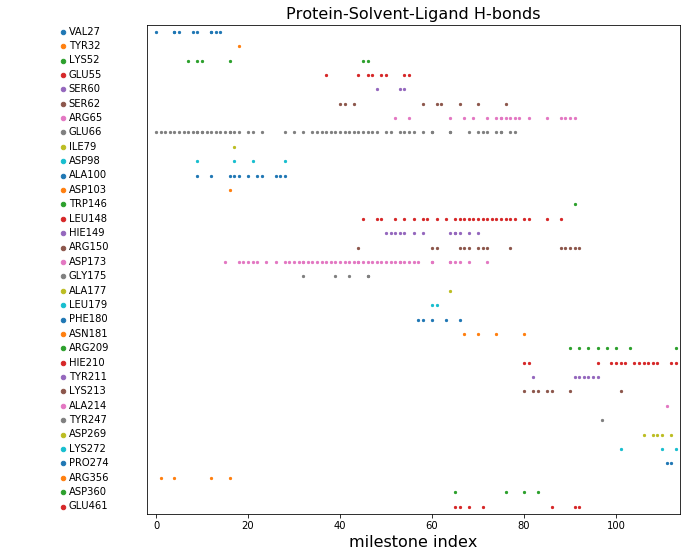

In [52]:
plt.figure(figsize=(12,9))

# subplot 1 for y-ticks and bullet points
fig = plt.subplot2grid((10, 10), (0, 0), rowspan=10)

x = 1.1
for i in range(len(Rorder)):
    y = len(Rorder)-i    
    plt.scatter(x,y,s=20)
    R = df_bridge[df_bridge.iloc[:,2]==Rorder[i]].iloc[0,1]
    plt.text(x+0.13,y-0.15, "%-3s%-d"%(R,int(Rorder[i])))

plt.xlim(0,1.2)
plt.ylim(0.5,len(Rorder)+0.5)
plt.yticks(np.arange(1, len(Rorder)+1, 1.0))
plt.yticks([])

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# remove all the ticks and directly label each bar with respective value
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='off')

#########################################################################################################

# subplot 2 for H bonds
fig = plt.subplot2grid((10, 10), (0, 2), colspan=9,rowspan=10)
x = np.array(df_bridge.iloc[:,0])
y = np.array(df_bridge.iloc[:,2])
for i in range(len(Rorder)):
    index = y == Rorder[i]
    x_ = x[index]
    y_ = [len(Rorder)-i]*len(x_)
    plt.scatter(x_,y_,s=5)

plt.setp(fig.get_yticklabels(),visible=False)
plt.yticks([])
plt.ylim(0.5,len(Rorder)+0.5)
plt.xlim([-2, num_milestones])
plt.xlabel("milestone index",fontsize=16)
plt.title("Protein-Solvent-Ligand H-bonds",fontsize=16)
plt.savefig('/home/si_han/Desktop/uf/WeiChen/002_UVU.pdf')
plt.show()

# Generate a 2D animation of H-bond donors and acceptors over milestones

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

In [6]:
DA_DIR = hbond_path+'/DA'
%mkdir {DA_DIR}

In [8]:
# pandas dada frame of protein-ligand H-bonds generated from Milestoning_Analysis
df_UU = pd.read_csv(hbond_path+'/df_UU.csv',delimiter='\t')

# pdb file of the ligand molecule generated from VMD (we need atom names)
# to obtain correct aromaticity, use open babel to make a mol file from pdb
pdb = pd.read_csv(DA_DIR+'/ligand.pdb',delimiter='\s+',header=None,skiprows=1)
pdb = pdb[pdb[0]=='ATOM']

In [9]:
pdb

,0,1,2,3,4,5,6,7,8,9,10,11
0,ATOM,1.0,C7,MOL,X,620.0,51.989,58.401,44.169,1.0,0.0,C
1,ATOM,2.0,S1,MOL,X,620.0,52.096,58.087,42.461,1.0,0.0,S
2,ATOM,3.0,C6,MOL,X,620.0,50.360,58.117,42.586,1.0,0.0,C
3,ATOM,4.0,S2,MOL,X,620.0,49.211,57.227,41.604,1.0,0.0,S
4,ATOM,5.0,C3,MOL,X,620.0,49.591,57.924,40.002,1.0,0.0,C
5,ATOM,6.0,N1,MOL,X,620.0,50.523,58.810,39.840,1.0,0.0,N
6,ATOM,7.0,C1,MOL,X,620.0,50.487,59.062,38.496,1.0,0.0,C
7,ATOM,8.0,C2,MOL,X,620.0,49.464,58.326,37.930,1.0,0.0,C
8,ATOM,9.0,N4,MOL,X,620.0,48.961,57.501,38.849,1.0,0.0,N
9,ATOM,10.0,C12,MOL,X,620.0,48.174,56.273,38.557,1.0,0.0,C


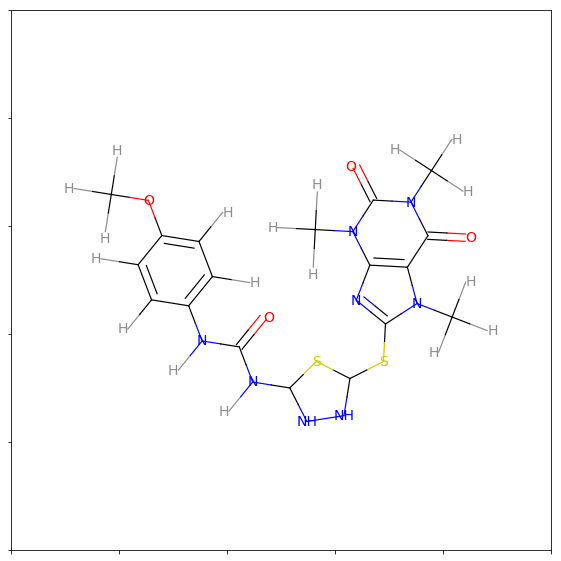

In [10]:
# Construct 2D molecule
ligand_mol = Chem.MolFromMolFile(DA_DIR+'/ligand.mol', sanitize=True)
ligand_pdb = Chem.MolFromPDBFile(DA_DIR+'/ligand.pdb', removeHs=False, sanitize=True)
ligand = AllChem.AssignBondOrdersFromTemplate(ligand_mol,ligand_pdb)
AllChem.Compute2DCoords(ligand)
figure = Chem.Draw.MolToMPL(ligand)

In [13]:
# extract H-bonding D/A atoms of the ligand, and the corresponding index 
for k in range(113):
    index = df_UU['milestone']==k
    df_UU[index]['ligand atom']
    atomlist = list(df_UU[index]['ligand atom'])
    atomlist = list(set(atomlist))
    highlight = np.array(pdb.loc[pdb[2].isin(atomlist)][1]-1,dtype=int).tolist()
    print('Milestone %d'%k)
    print('D/A atoms: '+str(atomlist))

    # Create color dictionary for each selected ligand atom
    colors = {}
    values = [(0,1,0)]
    for _,i in enumerate(highlight):
            colors[i] = values[0]
    # print(colors)


    # Draw 
    drawer = rdMolDraw2D.MolDraw2DSVG(400,350)
    drawer.DrawMolecule(ligand,highlightAtoms=highlight,highlightAtomColors=colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
#     display(SVG(svg))
    fh = open(DA_DIR+"/DA_%d.svg"%k, "w")
    fh.write(drawer.GetDrawingText())
    fh.close()

Milestone 0
D/A atoms: ['H2', 'O2', 'H1', 'O1', 'O3']
Milestone 1
D/A atoms: ['H2', 'O2', 'N6', 'H1', 'O1', 'O3']
Milestone 2
D/A atoms: ['H2', 'O2', 'N6', 'H1', 'O1', 'O3']
Milestone 3
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 4
D/A atoms: ['H2', 'O2', 'N6', 'H1', 'O1', 'O3']
Milestone 5
D/A atoms: ['H2', 'N6', 'H1', 'O1', 'O3']
Milestone 6
D/A atoms: ['H2', 'N6', 'H1', 'O1', 'O3']
Milestone 7
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 8
D/A atoms: ['H2', 'N5', 'N6', 'H1', 'O1', 'O3']
Milestone 9
D/A atoms: ['H2', 'N5', 'H1', 'O1', 'O3']
Milestone 10
D/A atoms: ['H2', 'O2', 'H1', 'O1', 'O3']
Milestone 11
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 12
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 13
D/A atoms: ['H2', 'N6', 'H1', 'O1', 'O3']
Milestone 14
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 15
D/A atoms: ['H1', 'O1', 'H2', 'O3']
Milestone 16
D/A atoms: ['H1', 'H2', 'O3']
Milestone 17
D/A atoms: ['H1', 'H2', 'O3']
Milestone 18
D/A atoms: ['H1', 'H2', 'O3']
Milestone 19


## compile GIFs to get an animation

In [16]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
import imageio

font = ImageFont.truetype('/usr/share/fonts/truetype/ubuntu-font-family/Ubuntu-B.ttf', size=35)
(x, y) = (0, 0)
color = 'rgb(0,0,0)' # black color

num_frames = 113

images = []
for i in range(num_frames):
    image = Image.open(DA_DIR+'/DA_%d.gif'%i).convert('RGBA')
    layer = Image.new('RGBA', image.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(image)
    name = 'M = %d'%i   
    draw.text((x, y), name, fill=color, font=font)
    image = Image.alpha_composite(image, layer)
    images.append(image)

images = np.stack(images)
imageio.mimsave(DA_DIR+'/All.gif',images,duration=11/num_frames)